In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm
import torch
import copy

In [3]:
python_file_location = '/content/drive/MyDrive/Colab_Notebooks/scripts'
sys.path.append(os.path.abspath(python_file_location))
data_file_location = '/content/drive/MyDrive/Colab_Notebooks/data'
sys.path.append(os.path.abspath(data_file_location))
%cd drive/MyDrive/Colab_Notebooks
%pwd

from scripts.visualization import Visualization
import scripts.dataset as DataSet
from scripts.safety import SafetyAlgorithm
import networks

/content/drive/MyDrive/Colab_Notebooks


In [4]:
path_to_labels = os.path.join("data", "dataset", "labels", "coco_labels.json")
path_to_data = os.path.join("data", "dataset", "coco_dataset", "val2017")
path_to_annotations = os.path.join("data", "dataset", "coco_dataset", "annotations", "instances_val2017.json")
dataset = DataSet.CocoDataSet(path_to_data, path_to_annotations, path_to_labels)

global_models_names = ["fasterrcnn_resnet50_fpn", "ssdlite320_mobilenet_v3_large", "yolov5", "detr"]
# global_models_names = ["ssdlite320_mobilenet_v3_large"]
global_jsons_paths = collections.defaultdict(list)
global_logging_paths = collections.defaultdict(list)
global_analyzed_classes = "person"
analyzed_labels = ["person", "car", "bicycle", "motorcycle", "bus", "train",
                   "truck", "traffic light", "street sign", "stop sign"]
remove_string = ["head.", "module_list.", ".weight", "backbone.body.", "backbone.", "roi_heads."]

global_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loading annotations into memory...
Done (t=1.59s)
creating index...
index created!


In [5]:
def walk_logging_directory():
    for models_name in global_models_names:
        data_path = os.path.join("data", "logging", models_name)  # , "jsons")
        list_of_dirs = os.listdir(data_path)
        for files in list_of_dirs:
            if os.path.isfile(os.path.join(data_path, files)) and files.split(".")[-1] == "json":
                global_jsons_paths[models_name].append(os.path.join(data_path, files))
                logging_path = os.path.join("data", "logging", models_name, "criticality")
                if not os.path.exists(logging_path):
                    os.makedirs(logging_path)
                global_logging_paths[models_name].append(logging_path)
    print(global_jsons_paths)


def concatenate_jsons(_model_name, _json_paths):
    statistics_dict = None
    for count, json_path in enumerate(_json_paths):
        print("Concatenating file {}".format(json_path))
        json_file = open(json_path, 'r')
        if count == 0:
            statistics_dict = json.load(json_file)
        else:
            temp_stats = json.load(json_file)
            for class_name, layers in temp_stats.items():
                for layer_name, kernels in layers.items():
                    for kernel_index, criticalities in kernels.items():
                        for image_index, image_criticality in criticalities.items():
                            statistics_dict[class_name][layer_name][kernel_index][image_index] = image_criticality
        json_file.close()

    def nested_dict():
        return collections.defaultdict(nested_dict)

    concatenated_statistics_dict = nested_dict()
    for class_name, layers in tqdm(statistics_dict.items()):
        for layer_name, kernels in layers.items():
            for kernel_index, criticalities in kernels.items():
                flattened_list = list()
                for image_index, image_criticality in criticalities.items():
                    # to remove all criticalities not related to the object
                    if -0.001 > image_criticality or image_criticality > 0.001:
                        flattened_list.append(image_criticality)
                if len(flattened_list) == 0:
                    concatenated_statistics_dict[class_name][layer_name][kernel_index] = [0.0, 0.0]
                else:
                    mean = np.mean(np.asarray(flattened_list, dtype=float))
                    std = np.std(np.asarray(flattened_list, dtype=float))
                    concatenated_statistics_dict[class_name][layer_name][kernel_index] = [mean, std]

    with open(os.path.join("data", "logging", _model_name, "concatenated_criticality_mean_std.json"),
              'w') as json_statistics:
        json.dump(concatenated_statistics_dict, json_statistics)

In [6]:
def analyze_and_save_statistics():
    # should be allowed only if there was concatenated json as input
    for model_name, json_paths in tqdm(global_jsons_paths.items()):
        json_file = open(json_paths[0], 'r')
        statistics_dict = json.load(json_file)

        logging_path = global_logging_paths[model_name][0]
        # layers_dict[filtered_labels][layers_name][str(kernel_index)][str(counter * batch_size + image_index)]
        number_of_classes = len(statistics_dict.keys())
        classes = list(statistics_dict.keys())
        list_of_layers = list(statistics_dict[classes[0]].keys())
        print("Statistics will be plotted for model {}\n".format(model_name))

        most_critical_neurons, anti_critical_neurons = Visualization.calculate_statistics(statistics_dict,
                                                                                          model_name, logging_path)
        with open(os.path.join(logging_path, 'most_critical_neurons.json'), 'w') as f:
            json.dump(most_critical_neurons, f)
        with open(os.path.join(logging_path, 'anti_critical_neurons.json'), 'w') as f:
            json.dump(anti_critical_neurons, f)


def find_overlapping_neurons():
    for model_name, json_paths in tqdm(global_jsons_paths.items()):
        print("Analysing anti-criticality for model {}".format(model_name))
        logging_path = global_logging_paths[model_name][0]

        json_file = open(os.path.join(logging_path, 'anti_critical_neurons.json'), 'r')
        anti_critical_neurons = json.load(json_file)
        json_file.close()
        logging_path_intersection = os.path.join("data", "logging", model_name, "intersections", "anti_critical")
        Visualization.find_overlapping_critical_neurons(anti_critical_neurons, logging_path_intersection)

        print("Analysing worst criticality for model {}".format(model_name))
        json_file = open(os.path.join(logging_path, 'most_critical_neurons.json'), 'r')
        most_critical_neurons = json.load(json_file)
        json_file.close()
        logging_path_intersection = os.path.join("data", "logging", model_name, "intersections", "critical")
        Visualization.find_overlapping_critical_neurons(most_critical_neurons, logging_path_intersection)


def neurons_clustering():
    from tqdm import tqdm
    import json

    for models_name, json_path in global_jsons_paths.items():

        json_file = open(json_path[0], 'r')
        statistics_dict = json.load(json_file)
        json_file.close()

        logging_path = os.path.join("data", "logging", models_name)

        local_analyzed_labels = list()
        list_of_layers = list()
        print("Neurons clustering will be plotted for {}".format(models_name))
        for layer in list(statistics_dict[global_analyzed_classes].keys()):
            name = copy.deepcopy(layer)
            for remove_str in remove_string:
                name = name.replace(remove_str, "")
                list_of_layers.append(name)

        layers_kernels_criticality_list = list()
        labels_indices = list()

        for index_label, (class_label, layers) in tqdm(enumerate(statistics_dict.items())):
            label_layers_kernels_criticality_list = list()
            layers_enumeration = list()
            layers_mean = list()

            if class_label in analyzed_labels:
                local_analyzed_labels.append(class_label)

                for layers_index, (layer, kernels) in enumerate(layers.items()):
                    for index, kernels_sum_cri_per_image in kernels.items():
                        if kernels_sum_cri_per_image[0] > 0.075 or kernels_sum_cri_per_image[0] < -0.075:
                            layers_kernels_criticality_list.append(kernels_sum_cri_per_image)
                            labels_indices.append(index_label)

                            label_layers_kernels_criticality_list.append(kernels_sum_cri_per_image)
                            layers_enumeration.append(layers_index)
                            layers_mean.append(kernels_sum_cri_per_image[0])

                # to assure that only deeply analyzed classes will be visualized
                if sum(mean > 0.05 for mean in layers_mean) < 10:
                    print("Skipping {} because criticality is too small {}".format(class_label, layers_mean[:5] + layers_mean[-5:]))
                    continue
                else:
                    Visualization.plot_scatter(list_of_layers, class_label, "Layers:",
                                               label_layers_kernels_criticality_list,
                                               layers_enumeration, logging_path)

        Visualization.plot_scatter(local_analyzed_labels, "all classes", "Classes:", layers_kernels_criticality_list,
                                   labels_indices, logging_path)



In [7]:
def visualize_statistics_offline():
    for models_name, json_paths in tqdm(global_jsons_paths.items()):

        json_file = open(json_paths[0], 'r')
        statistics_dict = json.load(json_file)

        logging_path = global_logging_paths[models_name][0]
        # layers_dict[filtered_labels][layers_name][str(kernel_index)][str(counter * batch_size + image_index)]
        number_of_classes = len(statistics_dict.keys())
        classes = list(statistics_dict.keys())
        list_of_layers = list(statistics_dict[classes[0]].keys())
        print("\n Statistics will be plotted for model {} \n".format(models_name))

        number_of_weights = 0
        for  layer_name, kernels in statistics_dict[global_analyzed_classes].items():
            number_of_weights += len(list(kernels.keys()))

        number_of_critical_neurons = 0
        total_criticality = 0.0
        number_of_most_critical_neurons = 0
        list_of_all_cricitalities = list()
        for  layer_name, kernels in statistics_dict[global_analyzed_classes].items():
            for kernel_index, criticalities in kernels.items():
                list_of_all_cricitalities.append(criticalities[0])
                if criticalities[0] > 0.001:
                    number_of_critical_neurons += 1
                    total_criticality += criticalities[0]
                if criticalities[0] > 1.0:
                    number_of_most_critical_neurons += 1

        logging_path = os.path.join("data", "logging", models_name)
        #_np_data, _bar_path, _name, _index, _labels, _title
        title = "Histogram of criticalities for model: " +  models_name
        Visualization.plot_histogram_of_confidence(np.asarray(list_of_all_cricitalities),
                                                   logging_path, models_name, title)


        print("Number of weights: {}".format(number_of_weights))
        print("Number of most critical neurons: {}".format(number_of_most_critical_neurons))
        print("Normalized criticality person: {}".format(total_criticality/number_of_critical_neurons))

        def nested_dict():
            return collections.defaultdict(nested_dict)
        joined_ap_statistics_dict = nested_dict()

        
        json_name = "ap_statistics_dict.json"
        mAP_logging_path = os.path.join(logging_path, "mAP")
        jsons_paths = [[mAP_logging_path, "anti"], [mAP_logging_path, "most"]]

        for mAP_path, anti_or_worse in jsons_paths:
            with open(os.path.join(mAP_path, anti_or_worse+json_name), 'r') as infile:
                ap_statistics_dict = json.load(infile)
            for label, layers in ap_statistics_dict.items():
                for layer, mAPs_list in layers.items():   
                    joined_ap_statistics_dict[anti_or_worse][label][layer] = mAPs_list[0]

        
        for anti_or_worse, labels in joined_ap_statistics_dict.items():
            all_class_layers_kernels = labels["all"]
            custom_class_layers_kernels = labels[global_analyzed_classes]
            not_masked_ap = custom_class_layers_kernels["not_masked"]
            if anti_or_worse == "anti":
                all_class_sorted_dict = dict(sorted(all_class_layers_kernels.items(), key=lambda item: item[1], reverse=True))
                custom_class_sorted_dict = dict(sorted(custom_class_layers_kernels.items(), key=lambda item: item[1], reverse=True))
            else:
                all_class_sorted_dict = dict(sorted(all_class_layers_kernels.items(), key=lambda item: item[1], reverse=True))
                custom_class_sorted_dict = dict(sorted(custom_class_layers_kernels.items(), key=lambda item: item[1]))

            kernels_criticalities = [value for layers_kernel, value in custom_class_sorted_dict.items()]
            if anti_or_worse == "anti":
                extreme_value_ap = max(kernels_criticalities)
            else:
                extreme_value_ap = min(kernels_criticalities)
            print("Class {}, not masked AP value {}".format(global_analyzed_classes, not_masked_ap))
            print("Class {}, {} AP value {}".format(global_analyzed_classes, anti_or_worse, extreme_value_ap ))

            kernels_criticalities = [value for layers_kernel, value in all_class_sorted_dict.items()]
            if anti_or_worse == "anti":
                extreme_value_ap = max(kernels_criticalities)
            else:
                extreme_value_ap = min(kernels_criticalities)
            print("For all classes not masked AP value {}".format(not_masked_ap))
            print("For all classes , {} AP value {}".format(anti_or_worse, extreme_value_ap ))
            
        #Visualization.plot_models_ap_criticality_correlation(models_name, "person", joined_ap_statistics_dict, mAP_logging_path)

In [8]:
def evaluate_AP(most_or_anti_neurons):
    original_mAP = True
    number_of_analyzed_neurons = 100
    ap_labels = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

    for models_name in global_models_names:

        count = 0
        logging_path = os.path.join("data", "logging", models_name)
        mAP_logging_path = os.path.join(logging_path, "mAP")
        if not os.path.exists(mAP_logging_path):
            os.makedirs(mAP_logging_path)

        def nested_dict():
            return collections.defaultdict(nested_dict)

        ap_statistics_dict = nested_dict()

        with open(os.path.join(logging_path, "criticality", most_or_anti_neurons + '_critical_neurons.json'),
                  'r') as json_file:
            critical_neurons = json.load(json_file)
        sorted_critical_neurons = Visualization.filter_neurons(critical_neurons, most_or_anti_neurons)

        model, parameter_dict, dataset = networks.take_a_model(models_name, global_device)
        safety = SafetyAlgorithm(model, dataset)

        # original mAP analysis
        masked_text = "original_mAP_unmasked"
        settings = {"fig_size": (6, 12),
                    "font_size": 10,
                    "show_numbers": True}
        filtered_classes = [label for label in dataset.labels if label != "N/A"]

        if original_mAP:
            ap_per_class_matrix, average_precision, dict_average_precisions = \
                model.predict_and_calculate_mean_average_precision(
                    mAP_logging_path,
                    masked_text + models_name,
                    ap_labels)

            ap_statistics_dict["all"]["not_masked"] = [average_precision]

            for class_index, ious in dict_average_precisions.items():
                if class_index == str(dataset.labels.index(global_analyzed_classes)):
                    ious_aps = [value for iou, value in ious.items()]
                    ap_statistics_dict[dataset.labels[int(class_index)]]["not_masked"] = [float(
                        sum(ious_aps) / len(ious_aps))]

            with open(os.path.join(mAP_logging_path, 'ap_statistics_dict.json'), 'w') as outfile:
                json.dump(ap_statistics_dict, outfile)

        for mean_value, labels in sorted_critical_neurons.items():
            for label, critical_neuron in labels.items():
                if label == global_analyzed_classes and count < number_of_analyzed_neurons:
                    param = parameter_dict[critical_neuron["layer"]]
                    layers_name = critical_neuron["layer"]

                    original_values = copy.deepcopy(param[0].data)
                    original_values.to(global_device)
                    masked_values = param[0].data
                    kernel_index = critical_neuron["kernel"]

                    safety.mask_kernel(masked_values, int(kernel_index))
                    masked_text = layers_name + "_masked_" + str(kernel_index) + "_labels_"
                    print("Masking layer {} kernel {}".format(layers_name, kernel_index))
                    ap_per_class_matrix, average_precision, dict_average_precisions = \
                        model.predict_and_calculate_mean_average_precision(mAP_logging_path,
                                                                            masked_text + models_name,
                                                                            ap_labels)
                    # dict_average_precisions[str(c)][str(iou_threshold)] = mAP
                    print("AP for class {}, {}".format(global_analyzed_classes,
                                                        str(dict_average_precisions[
                                                                dataset.labels.index(global_analyzed_classes)])))

                    ap_statistics_dict["all"][layers_name + "_" + kernel_index] = [average_precision,
                                                                                    mean_value]
                    for class_index, ious in dict_average_precisions.items():
                        if class_index == str(dataset.labels.index(global_analyzed_classes)):
                            ious_aps = [value for iou, value in ious.items()]
                            ap_statistics_dict[dataset.labels[int(class_index)]][
                                layers_name + "__" + kernel_index] = [float(
                                sum(ious_aps) / len(ious_aps)), mean_value]
                    # Visualization.plot_correlation_matrix(np.asarray(ap_per_class_matrix),
                    #                                      ap_labels,
                    #                                      filtered_classes[1:],
                    #                                      masked_text,
                    #                                      mAP_logging_path,
                    #                                      settings)
                    # unmasking the weights
                    safety.unmask_kernel(masked_values, original_values, int(kernel_index))
                    count += 1

                    with open(os.path.join(mAP_logging_path, most_or_anti_neurons + 'ap_statistics_dict.json'), 'w') as outfile:
                        json.dump(ap_statistics_dict, outfile)

        Visualization.plot_models_ap_criticality_correlation(models_name, ap_statistics_dict, mAP_logging_path, most_or_anti_neurons)


defaultdict(<class 'list'>, {'fasterrcnn_resnet50_fpn': ['data/logging/fasterrcnn_resnet50_fpn/concatenated_criticality_mean_std.json'], 'ssdlite320_mobilenet_v3_large': ['data/logging/ssdlite320_mobilenet_v3_large/concatenated_criticality_mean_std.json'], 'yolov5': ['data/logging/yolov5/concatenated_criticality_mean_std.json'], 'detr': ['data/logging/detr/concatenated_criticality_mean_std.json']})


  0%|          | 0/4 [00:00<?, ?it/s]


 Statistics will be plotted for model fasterrcnn_resnet50_fpn 



 25%|██▌       | 1/4 [00:08<00:25,  8.49s/it]

Number of weights: 31382
Number of most critical neurons: 2
Normalized criticality person: 0.029555381142378247
Class person, not masked AP value 43.97208350710571
Class person, anti AP value 44.549238020554185
For all classes not masked AP value 43.97208350710571
For all classes , anti AP value 39.707625545561314
Class person, not masked AP value 43.97208350710571
Class person, most AP value 0.0
For all classes not masked AP value 43.97208350710571
For all classes , most AP value 29.63572222739458

 Statistics will be plotted for model ssdlite320_mobilenet_v3_large 



 50%|█████     | 2/4 [00:14<00:14,  7.22s/it]

Number of weights: 40244
Number of most critical neurons: 33
Normalized criticality person: 0.04114283201918619
Class person, not masked AP value 21.10106648877263
Class person, anti AP value 21.165986489504576
For all classes not masked AP value 21.10106648877263
For all classes , anti AP value 19.63811580091715
Class person, not masked AP value 21.10106648877263
Class person, most AP value 9.042176962830126
For all classes not masked AP value 21.10106648877263
For all classes , most AP value 3.281642443034798

 Statistics will be plotted for model yolov5 



 75%|███████▌  | 3/4 [00:20<00:06,  6.35s/it]

Number of weights: 30781
Number of most critical neurons: 1
Normalized criticality person: 0.015094798912459947
Class person, not masked AP value 45.071900114417076
Class person, anti AP value 45.490490049123764
For all classes not masked AP value 45.071900114417076
For all classes , anti AP value 42.41976045072079
Class person, not masked AP value 45.071900114417076
Class person, most AP value 26.678242161870003
For all classes not masked AP value 45.071900114417076
For all classes , most AP value 20.13921730220318

 Statistics will be plotted for model detr 

Number of weights: 80576
Number of most critical neurons: 3
Normalized criticality person: 0.049068507615921


100%|██████████| 4/4 [00:31<00:00,  7.93s/it]

Class person, not masked AP value 20.34296377096325
Class person, anti AP value 23.97426421754062
For all classes not masked AP value 20.34296377096325
For all classes , anti AP value 25.831753835082054
Class person, not masked AP value 20.34296377096325
Class person, most AP value 0.6557859462191118
For all classes not masked AP value 20.34296377096325
For all classes , most AP value 0.8304803271312267


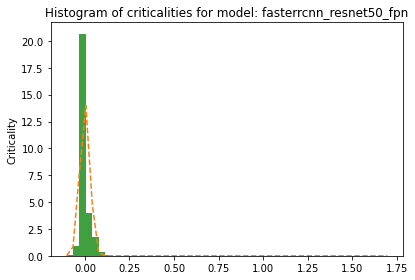

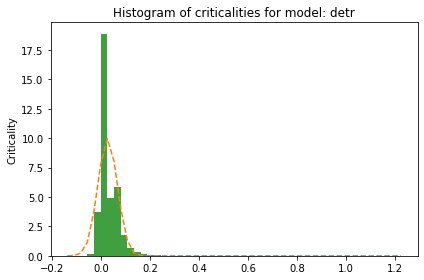

In [9]:
walk_logging_directory()
# for model_name, json_paths in tqdm(jsons_paths.items()):
#    concatenate_jsons(model_name, json_paths)
visualize_statistics_offline()
#analyze_and_save_statistics()
#find_overlapping_neurons()
#neurons_clustering()
#visualize_AP_offline()
#evaluate_AP("most")
#evaluate_AP("anti")